In [2]:
import numpy as np
import statistics
import math
import scipy.stats as scs
import matplotlib.pyplot as plt
import numpy.linalg as la
from pingouin import power_anova

For a population $P$, let $D^k$ be the demographic partitions of $P$ (Race, Gender, Sexuality, etc.) such that

$D^k := \{D^k_i : P = \sqcup_i D^k_i\}$ we need to know minimum $|D^k_i \cap D^m_j|, i \neq j, k \neq m$ given $|P|$.

#### het_prob_intersectional()
The probability that some individual $ x \in P$, is in a chosen class, $\omega$, within each partition $D^k$ is 

$p(x \in D^k_{\omega} \forall k) = \prod_k\prod_{i \neq \omega, i \in D^k}(1 - p(D_i^k))$

For example, the probability that $x$ is a straight white male is 

$(1 - p(D_{straight}^{sexuality}))(1 - p(D_{white}^{race}))(1 - p(D_{male}^{gender}))$

for the case where identities are perfectly heterogenously distributed in the pool,

$p(x \in D^k_{\omega} \forall k) = \prod_k [1-(1-\frac{1}{|D^k|})]^{|D^k-1|}$

Thus the function returns $p(x \in D^k_{\omega} \forall k)^{-1}$, or the number of people necessary in a heterogenous pool for one such $x$ to exist with 100% probability.

#### subset_bounds()

Bounding subset size:

Given partitions $D^k$, we know we have a total of $\prod_i |D^k_i|$ possible identities. We can set bounds on these by placing bounds on the size of each $D^k_i$ and then solve using an $(\sum_i |D^k_i|) \times (\prod_i |D^k_i|)$ matrix, $M$. 

For fixed size, $s$, in all demographic subgroups, this is solved as 
$Mx = s\vec{1}$

In [2]:
# Sample: 
# N is the total sample size (annotators * comments)
# S is the number of annotators
# Q is the number of comments to label PER ANNOTATOR
# subset_dict is a dictionary of the demographic subsets ex: {'gender': ['m', 'f', 'nb'], ...}

In [3]:
class Sample:
    
    def __init__(self,
                 N=None,
                 S=None, 
                 Q=None, 
                 subset_dict=None):
        
        self.subsets = subset_dict
        
        if (S and Q):
            self.S = S
            self.Q = Q
            self.N = S*Q
        
        elif (N and S):
            self.N = N
            self.S = S
            self.Q = int(N/S)
        
        elif (N and Q):
            self.N = N
            self.Q = Q
            self.S = int(N/Q)
        
        else:
            raise ValueError("Not enough values.")
            
            
            
    def het_prob_intersectional(self, subsets=None):
        
        l = []
        
        if subsets is None:
            subsets = self.subsets
        
        if type(subsets) == dict:
            for dem in subsets:
                k = len(subsets[dem])
                l.append((1 - (1 - 1/k))**(k-1))
            
        # this input is a list of the number of identities per demographic partition
        elif type(subsets) == list:
            for k in subsets:
                l.append((1 - (1 - 1/k))**(k-1))
        else:
            raise ValueError("No valid subset information provided.")
            
        return np.prod(l)**-1
    
    
            
    def cal_identity_subset_bounds(self, M, S):
        
        # there is a way to get M & S from self.subsets but I leave that for later
        
        return la.tensorsolve(M, S)
    
    # largest_partition is the number of identities in the demogrpahic split with the most identities
    def largest_effect_size(self, largest_partition):
        return power_anova(k=largest_partition, n=self.N, power=0.8, alpha=0.05)
    
    # dict_number_identities is a dictionary with the number of groups in each split
    # ex: {'race': 4, 'religion': 10}
    # sample_rate is the sample rate for np.linspace [0,sample_end]
    

In [15]:
def plot_anova_power(dict_number_identities, sample_rate=100, sample_start=0, sample_end=0.1):
        
        X = np.linspace(sample_start, sample_end, 100)
        y_k = {}
        
        for cat in dict_number_identities:
            y = []
            for i in X:
                y.append(power_anova(eta=i, k=dict_number_identities[cat], power=0.8, alpha=0.05))
            y_k[cat] = y
            
        for k in y_k:
            plt.plot(X, y_k[k], label=k)
        plt.ylabel('Sample Size per Group')
        plt.xlabel('Smallest Effect Size')
        plt.title('ANOVA Power Calculation')
        plt.legend()

## Examples

In [30]:
tst_population = Sample(N=1500, Q=100)

$\texttt{het_prob_intersectional()}$ scales $\textit{very}$ quickly when the number of possible identities increases.

In [40]:
print(tst_population.het_prob_intersectional([2,2]))
print(tst_population.het_prob_intersectional([2,3]))
print(tst_population.het_prob_intersectional([2,2,2,2]))
print(tst_population.het_prob_intersectional([3,3,3,3]))

4.0
18.000000000000007
16.0
6561.000000000012


(0.0, 1000.0)

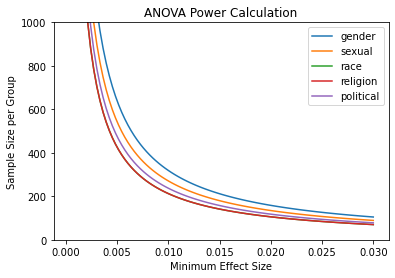

In [13]:
# plotting minimum effect size for demographics as per the labels in the **doc**
# using an ANOVA test

qualtrics_splits = {'gender': 3, 'sexual': 4, 'race': 6, 'religion': 6, 'political': 5}

plot_anova_power(qualtrics_splits, sample_rate=30, sample_end=0.03)
plt.ylim([0,1000])

In [6]:
# smallest effect size expected from the groups presented in the **docs**

qualtrics_N = {'gender': 335, 'sexual': 450, 'race': 745, 'religion': 600, 'political': 450}

for dem in qualtrics_N:
    p = power_anova(k=qualtrics_splits[dem], n=qualtrics_N[dem], power=0.8, alpha=0.05)
    print(f"Smallest Effect Size which can reject $H_0$ using ANOVA test in {dem}: {p}")

Smallest Effect Size which can reject $H_0$ using ANOVA test in gender: 0.009523885424984618
Smallest Effect Size which can reject $H_0$ using ANOVA test in sexual: 0.0060335360406451235
Smallest Effect Size which can reject $H_0$ using ANOVA test in race: 0.00286501554887624
Smallest Effect Size which can reject $H_0$ using ANOVA test in religion: 0.003555995745988282
Smallest Effect Size which can reject $H_0$ using ANOVA test in political: 0.005287673560240183


In [7]:
# smallest effect size expected from the groups presented in the **docs**

qualtrics_N = {'gender': 150, 'sexual': 150, 'race': 150, 'religion': 150, 'political': 150}

for dem in qualtrics_N:
    p = power_anova(k=qualtrics_splits[dem], n=qualtrics_N[dem], power=0.8, alpha=0.05)
    print(f"Smallest Effect Size which can reject $H_0$ using ANOVA test in {dem}: {p}")

Smallest Effect Size which can reject $H_0$ using ANOVA test in gender: 0.0210997325338543
Smallest Effect Size which can reject $H_0$ using ANOVA test in sexual: 0.01796191598535155
Smallest Effect Size which can reject $H_0$ using ANOVA test in race: 0.01413856757477921
Smallest Effect Size which can reject $H_0$ using ANOVA test in religion: 0.01413856757477921
Smallest Effect Size which can reject $H_0$ using ANOVA test in political: 0.015762857715490877


(0.0, 1000.0)

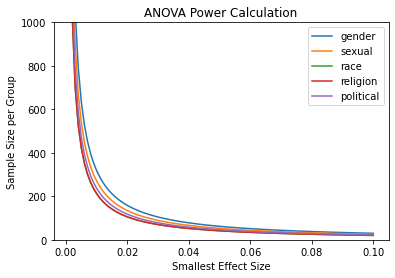

In [16]:
# plotting minimum effect size for demographics as per the labels in the Qualtrics doc
# using an ANOVA test

qualtrics_splits = {'gender': 3, 'sexual': 4, 'race': 6, 'religion': 6, 'political': 5}

plot_anova_power(qualtrics_splits)
plt.ylim([0,1000])